In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
import pickle as pkl

In [10]:
data = pd.read_csv('maladie_cardiaque.csv', usecols=lambda column: column != 'Unnamed: 0',index_col = 'id')

In [11]:
def transform_dataframe(data):
    # Ajouter une colonne 'age_annee'
    data["age_annee"] = round(data["age"]/365.25,2)

    # Créer les intervalles pour les classes d'âge
    bins = [0, 18, 30, 45, 60, 100]

    # Créer les étiquettes pour les classes d'âge
    labels = ['moins de 18 ans', '18-30 ans', '30-45 ans', '45-60 ans', 'plus de 60 ans']

    # Créer une nouvelle colonne 'classe_age' en utilisant la méthode cut()
    data['classe_age'] = pd.cut(data['age_annee'], bins=bins, labels=labels)

    # Convertir les colonnes 'malade', 'fumeur' et 'conso_alco' en 0/1
    data['malade'] = data["malade"].map({'oui': 1, 'non': 0})
    data['fumeur'] = data["fumeur"].map({'fumeur': 1, 'non fumeur': 0})
    data['conso_alco'] = data["conso_alco"].map({'oui': 1, 'non': 0})

    # Ajouter une colonne 'IMC_Category'
    def imc_category(row):
        taille_m = row['taille'] / 100  # Convertir la taille en mètres
        imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
        if imc < 18.5:
            return 'Maigre'
        elif imc < 25:
            return 'Normal'
        elif imc < 30:
            return 'Surpoids'
        else:
            return 'Obèse'
    data['IMC'] = data.apply(lambda row: row['Poids'] / ((row['taille'] / 100) ** 2), axis=1)
    data['IMC_Category'] = data.apply(imc_category, axis=1)


    # Appliquer get_dummies sur les colonnes catégorielles
    cat_cols = data.select_dtypes(exclude=['int64', 'float64']).columns
    cat_cols = list(cat_cols)
    cat_cols.append("glycemie")
    df_onehot = pd.get_dummies(data, columns=cat_cols)

    # Supprimer les colonnes non nécessaires
    df_onehot = df_onehot.drop(['classe_age_moins de 18 ans','genre_homme', 'age_annee', 'age', 'Poids', 'taille','IMC'], axis=1)

    return df_onehot


In [12]:
df = transform_dataframe(data)

In [13]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df[['pression_systo', 'pression_diasto']] = scale.fit_transform(df[['pression_systo', 'pression_diasto']])
#selector = VarianceThreshold(threshold = 0.0001)
#df = selector.fit_transform(df)

In [14]:
df.shape

(70000, 21)

In [15]:
df

,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,genre_femme,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,...,classe_age_30-45 ans,classe_age_45-60 ans,classe_age_plus de 60 ans,IMC_Category_Maigre,IMC_Category_Normal,IMC_Category_Obèse,IMC_Category_Surpoids,glycemie_1,glycemie_2,glycemie_3
id,,,,,,,,,,,,,,,,,,,,,
0,-0.122182,-0.088238,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0.072610,-0.035180,0,0,1,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.007679,-0.141297,0,0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.137541,0.017879,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
4,-0.187113,-0.194356,0,0,0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,-0.057251,-0.088238,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
99995,0.072610,-0.035180,0,0,1,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
99996,0.332333,-0.035180,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [ ]:
###Entraînement de modèles avec l'ensemble des variables

In [47]:
# Séparer les variables cibles et les variables prédictives
X = df.drop('malade', axis=1)
y = df['malade']
#X = selector.fit_transform(X)
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Créer un objet RandomForestClassifier avec des paramètres par défaut
rfc = RandomForestClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
rfc.fit(X_train, y_train)

# Évaluer les performances du modèle sur l'ensemble de test
score = rfc.score(X_test, y_test)

# Afficher le score
print('Score : {:.4f}'.format(score))

Score : 0.7150


In [48]:
rfc = RandomForestClassifier()
#from sklearn.linear_model import LogisticRegression
#rfc = LogisticRegression()
rfecv = RFECV(estimator=rfc, cv=3)
# Appliquer RFECV sur les données d'entraînement
rfecv.fit(X_train, y_train)

# Afficher le nombre de variables sélectionnées
print('Nombre de variables sélectionnées : {}'.format(rfecv.n_features_))

# Afficher les noms de colonnes des variables sélectionnées
print('Variables sélectionnées :')
for col in X.columns[rfecv.support_]:
    print(col)

Nombre de variables sélectionnées : 6
Variables sélectionnées :
pression_systo
pression_diasto
cholesterol_normal
cholesterol_tres eleve
classe_age_30-45 ans
classe_age_plus de 60 ans


In [53]:
#with open('rfecv.pkl', 'wb') as f:
#    pkl.dump(rfecv,f)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


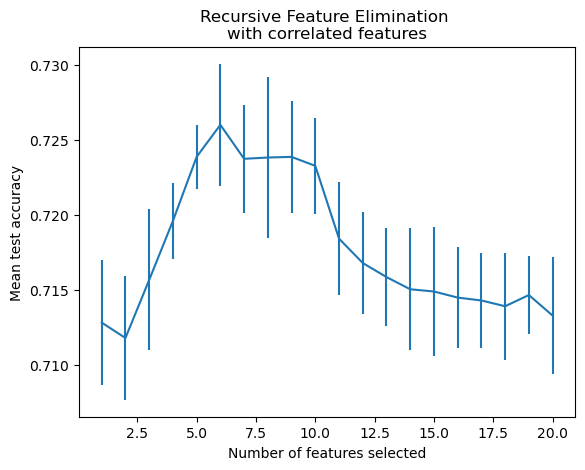

In [19]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, len(rfecv.grid_scores_) + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [20]:
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

In [21]:
rfc = RandomForestClassifier()

# Entraîner le modèle sur l'ensemble d'entraînement
rfc.fit(X_train, y_train)

# Évaluer les performances du modèle sur l'ensemble de test
score = rfc.score(X_test, y_test)

In [22]:
print(score)

0.7280952380952381


In [23]:
import itertools

def print_nice_conf_matrix(y, cnf_matrix):
    '''
    Fonction dediee a rendre une jolie matrice de confusion a partir de :
        - y : un array contenant les classes pour la classification. 
               Sert uniquement a compter le nombre de classes.
        - cnf_matrix : la matrice de confusion qui nous interesse.
    '''
    classes = range(0,(len(np.unique(y))))

    plt.figure()

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

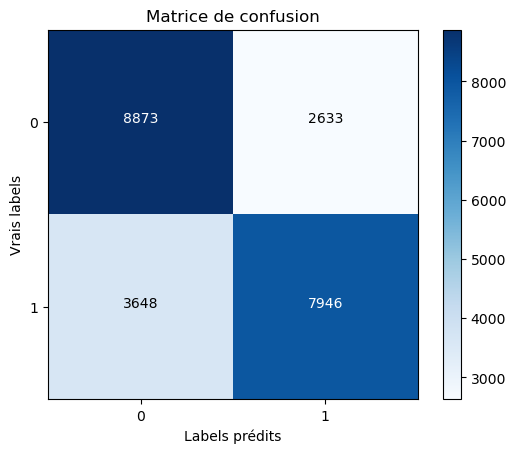

Confusion Matrix:
 None
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74     11506
           1       0.75      0.69      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# obtenir les prédictions pour chaque classe
pred = rfc.predict(X_test)

# créer la matrice de confusion
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", print_nice_conf_matrix(y_test, cm))

# créer le rapport de classification
report = classification_report(y_test, pred)
print("Classification Report:\n", report)





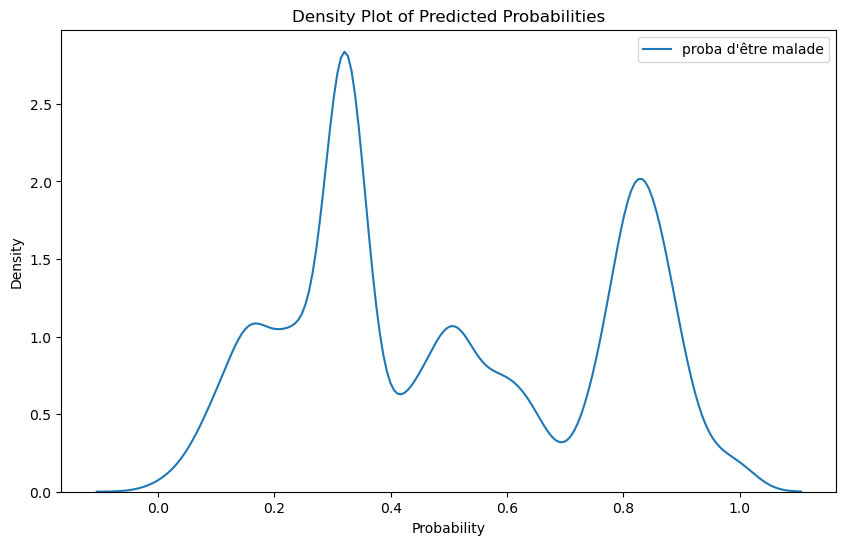

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
proba_pred  = rfc.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()


In [31]:
X = df.drop('malade', axis=1)
y = df['malade']

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

rfecv = RFECV(estimator=lr, cv=3)
# Appliquer RFECV sur les données d'entraînement
rfecv.fit(X_train, y_train)

# Afficher le nombre de variables sélectionnées
print('Nombre de variables sélectionnées : {}'.format(rfecv.n_features_))

# Afficher les noms de colonnes des variables sélectionnées
print('Variables sélectionnées :')
for col in X.columns[rfecv.support_]:
    print(col)

Nombre de variables sélectionnées : 2
Variables sélectionnées :
pression_systo
cholesterol_tres eleve


In [32]:
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

In [34]:
lr.fit(X_train, y_train)

LogisticRegression()

In [35]:
lr.score(X_test, y_test)

0.7296969696969697

In [37]:
y_lr = lr.predict(X_test)

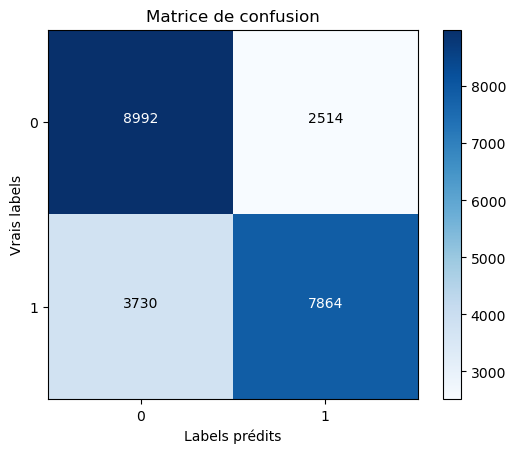

Confusion Matrix:
 None
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74     11506
           1       0.76      0.68      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



In [38]:
# créer la matrice de confusion
cm = confusion_matrix(y_test, y_lr)
print("Confusion Matrix:\n", print_nice_conf_matrix(y_test, cm))

# créer le rapport de classification
report = classification_report(y_test, y_lr)
print("Classification Report:\n", report)

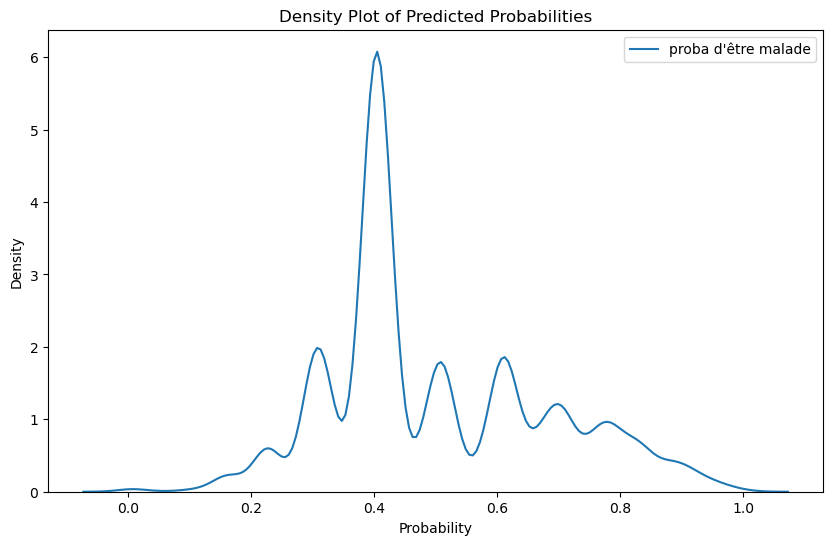

In [39]:
proba_pred  = lr.predict_proba(X_test)


# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10,6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()